In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import pickle
from sklearn.metrics import f1_score, confusion_matrix
import json
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score

In [ ]:
with open('Subtask_1_train.json', 'r') as f:
    data = json.load(f)

In [ ]:
data[0:5]

[{'conversation_ID': 1,
  'conversation': [{'utterance_ID': 1,
    'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .',
    'speaker': 'Chandler',
    'emotion': 'neutral'},
   {'utterance_ID': 2,
    'text': 'Oh , yeah . Had that dream .',
    'speaker': 'All',
    'emotion': 'neutral'},
   {'utterance_ID': 3,
    'text': 'Then I look down , and I realize there is a phone ... there .',
    'speaker': 'Chandler',
    'emotion': 'surprise'},
   {'utterance_ID': 4,
    'text': 'Instead of ... ?',
    'speaker': 'Joey',
    'emotion': 'surprise'},
   {'utterance_ID': 5,
    'text': 'That is right .',
    'speaker': 'Chandler',
    'emotion': 'anger'},
   {'utterance_ID': 6,
    'text': 'Never had that dream .',
    'speaker': 'Joey',
    'emotion': 'neutral'},
   {'utterance_ID': 7,
    'text': 'No .',
    'speaker': 'Phoebe',
    'emotion': 'neutral'},
   {'utterance_ID': 8,
    'text': 'All of a sudden , the

In [ ]:
# Extracting data from the list of dictionaries
conversation_data = []
for conv in data:
    conv_id = conv['conversation_ID']
    for utt in conv['conversation']:
        utterance_id = utt['utterance_ID']
        text = utt['text']
        speaker = utt['speaker']
        emotion = utt['emotion']
        emotion_cause_pairs = conv['emotion-cause_pairs']
        conversation_data.append((conv_id, utterance_id, text, speaker, emotion, emotion_cause_pairs))

# Create DataFrame
train_df = pd.DataFrame(conversation_data, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker', 'Emotion', 'Emotion_Cause_Pairs'])

# Display DataFrame
train_df


,Conversation_ID,Utterance_ID,Text,Speaker,Emotion,Emotion_Cause_Pairs
0,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,"[[3_surprise, 1_I realize I am totally naked ...."
1,1,2,"Oh , yeah . Had that dream .",All,neutral,"[[3_surprise, 1_I realize I am totally naked ...."
2,1,3,"Then I look down , and I realize there is a ph...",Chandler,surprise,"[[3_surprise, 1_I realize I am totally naked ...."
3,1,4,Instead of ... ?,Joey,surprise,"[[3_surprise, 1_I realize I am totally naked ...."
4,1,5,That is right .,Chandler,anger,"[[3_surprise, 1_I realize I am totally naked ...."
...,...,...,...,...,...,...
13614,1374,1,"I never sucked , I actually did not want you t...",Chandler,neutral,"[[2_surprise, 1_I never sucked , I actually di..."
13615,1374,2,Why ?,Monica,surprise,"[[2_surprise, 1_I never sucked , I actually di..."
13616,1374,3,I do not know .,Chandler,neutral,"[[2_surprise, 1_I never sucked , I actually di..."
13617,1374,4,This is so great ! Now we can enter into doubl...,Monica,joy,"[[2_surprise, 1_I never sucked , I actually di..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13619 entries, 0 to 13618
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Conversation_ID      13619 non-null  int64 
 1   Utterance_ID         13619 non-null  int64 
 2   Text                 13619 non-null  object
 3   Speaker              13619 non-null  object
 4   Emotion              13619 non-null  object
 5   Emotion_Cause_Pairs  13619 non-null  object
dtypes: int64(2), object(4)
memory usage: 638.5+ KB


In [ ]:
# Summary Statistics
summary_stats = train_df.describe(include='all')
summary_stats

,Conversation_ID,Utterance_ID,Text,Speaker,Emotion,Emotion_Cause_Pairs
count,13619.000000,13619.000000,13619,13619,13619,13619
unique,NaN,NaN,12090,312,7,1268
top,NaN,NaN,Hey !,Joey,neutral,[]
freq,NaN,NaN,111,2044,5929,351
mean,684.063221,7.063955,NaN,NaN,NaN,NaN
std,396.509789,4.923525,NaN,NaN,NaN,NaN
min,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,346.000000,3.000000,NaN,NaN,NaN,NaN
50%,684.000000,6.000000,NaN,NaN,NaN,NaN
75%,1027.000000,10.000000,NaN,NaN,NaN,NaN


In [ ]:
# Data Types
data_types = train_df.dtypes
data_types

Conversation_ID         int64
Utterance_ID            int64
Text                   object
Speaker                object
Emotion                object
Emotion_Cause_Pairs    object
dtype: object

In [ ]:
# Missing Values
missing_values = train_df.isnull().sum()
missing_values

Conversation_ID        0
Utterance_ID           0
Text                   0
Speaker                0
Emotion                0
Emotion_Cause_Pairs    0
dtype: int64

In [ ]:
# Emotion Distribution
emotion_distribution = train_df['Emotion'].value_counts()
emotion_distribution

neutral     5929
joy         2301
surprise    1840
anger       1615
sadness     1147
disgust      414
fear         373
Name: Emotion, dtype: int64

In [ ]:
# Speaker Distribution
speaker_distribution = train_df['Speaker'].value_counts()
speaker_distribution

Joey                 2044
Ross                 2026
Rachel               1950
Phoebe               1779
Monica               1767
                     ... 
Drunken Gambler         1
Joey and Chandler       1
Guys                    1
A Student               1
Professore Clerk        1
Name: Speaker, Length: 312, dtype: int64

In [ ]:
unique_speakers = train_df['Speaker'].unique()
print(unique_speakers)


['Chandler' 'All' 'Joey' 'Phoebe' 'Ross' 'Monica' 'Paul' 'Rachel'
 'Mrs. Geller' 'Mr. Geller' 'Susan' 'Carol' 'Barry' 'Robbie' 'Paula'
 'Kiki' 'Joanne' 'Receptionist' 'Pizza Guy' 'Monica and Phoebe' 'Both'
 'Kid' 'Janice' 'Woman' 'Angela' 'Bob' 'Director' 'Jill' 'Shelley'
 'Aunt Lillian' 'Jay Leno' 'Paolo' 'Customer' 'Joey and Chandler' 'Guys'
 'Mr. Tribbiani' 'Ronni' 'Mrs. Tribbiani' 'Roger' 'Lorraine' 'Kristin'
 'Rachel and Phoebe' 'Fireman No. 1' 'Fireman No. 2' 'Fireman No. 3'
 'Mrs. Tedlock' 'Joey and Ross' 'Bernice' 'Bobby' 'Mindy' 'Teacher'
 'Dr. Baldhara' 'Fake Monica' 'Young Ethan' 'Gerston' 'Santos' 'Petrie'
 'Lydia' 'Nurse' 'Guy' 'Dr. Franzblau' 'Janitor' 'Flight Attendant' 'Man'
 'Carl' 'Julie' 'Annabelle' 'Hombre Man' 'Mr. Heckles' 'Mr. Treeger'
 'Stranger' 'Duncan' 'Jade' 'Steve' 'Terry' 'Chandler and Joey' 'Doctor'
 'Frank' 'Girl' 'Isabella' 'Eric' 'Friend No. 2' 'Friend No. 1'
 'Her-Friends' 'Student' 'Jester' 'The Guys' 'Sarah' 'Leader' 'Gunther'
 'Mark' 'Jeannine' 'Ju

In [ ]:
# Splitting the text into words and calculating the number of words in each utterance
word_count_distribution = train_df['Text'].apply(lambda x: len(x.split()))

# Displaying the distribution of the number of words
print("Distribution of Number of Words in Each Utterance:")
print(word_count_distribution)


Distribution of Number of Words in Each Utterance:
0        28
1         8
2        15
3         4
4         4
         ..
13614    17
13615     2
13616     5
13617    13
13618     4
Name: Text, Length: 13619, dtype: int64


In [ ]:
# Extracting data from the list of dictionaries
conversation_data = []
for conv in data:
    conv_id = conv['conversation_ID']
    for utt in conv['conversation']:
        utterance_id = utt['utterance_ID']
        text = utt['text']
        speaker = utt['speaker']
        emotion = utt['emotion']
        emotion_cause_pairs = conv['emotion-cause_pairs']
        for emotion_id, cause in emotion_cause_pairs:
            emotion_category, _ = emotion_id.split('_')
            conversation_data.append((conv_id, utterance_id, text, speaker, emotion, emotion_category, cause, (emotion_id, cause)))

# Create DataFrame
train_df = pd.DataFrame(conversation_data, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker', 'Emotion', 'Emotion_Category', 'Cause', 'Emotion_Cause_Pair'])

# Display DataFrame
train_df

,Conversation_ID,Utterance_ID,Text,Speaker,Emotion,Emotion_Category,Cause,Emotion_Cause_Pair
0,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,3,1_I realize I am totally naked .,"(3_surprise, 1_I realize I am totally naked .)"
1,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,3,"3_Then I look down , and I realize there is a ...","(3_surprise, 3_Then I look down , and I realiz..."
2,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,4,1_I realize I am totally naked .,"(4_surprise, 1_I realize I am totally naked .)"
3,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,4,"3_Then I look down , and I realize there is a ...","(4_surprise, 3_Then I look down , and I realiz..."
4,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,4,4_Instead of ...,"(4_surprise, 4_Instead of ...)"
...,...,...,...,...,...,...,...,...
126311,1374,3,I do not know .,Chandler,neutral,4,4_Now we can enter into doubles tournaments !,"(4_joy, 4_Now we can enter into doubles tourna..."
126312,1374,4,This is so great ! Now we can enter into doubl...,Monica,joy,2,"1_I never sucked , I actually did not want you...","(2_surprise, 1_I never sucked , I actually did..."
126313,1374,4,This is so great ! Now we can enter into doubl...,Monica,joy,4,4_Now we can enter into doubles tournaments !,"(4_joy, 4_Now we can enter into doubles tourna..."
126314,1374,5,That is why !,Chandler,neutral,2,"1_I never sucked , I actually did not want you...","(2_surprise, 1_I never sucked , I actually did..."


<ipython-input-14-8f7e113c63f2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=train_df, palette='viridis')


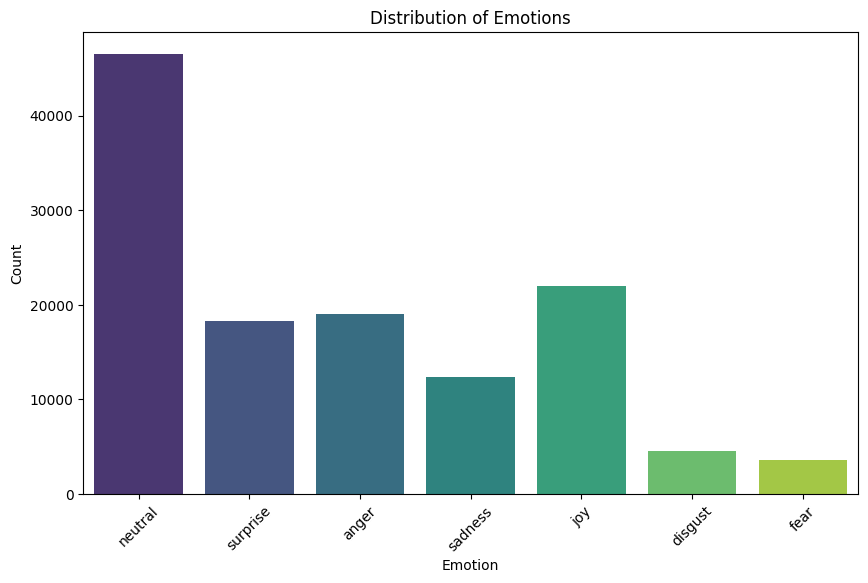

In [ ]:
# Plotting the distribution of emotions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=train_df, palette='viridis')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


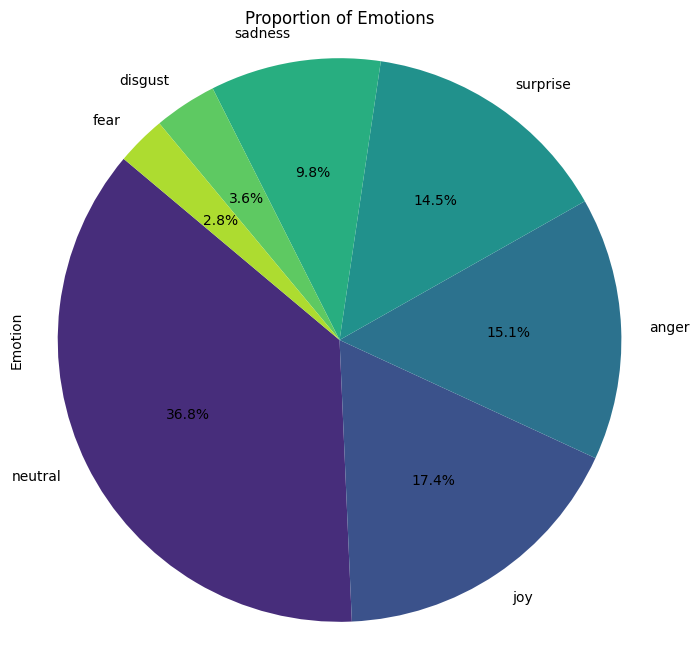

In [ ]:
# Pie chart for the proportion of each emotion
plt.figure(figsize=(8, 8))
train_df['Emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(train_df['Emotion'].unique())))
plt.title('Proportion of Emotions')
plt.axis('equal')
plt.show()


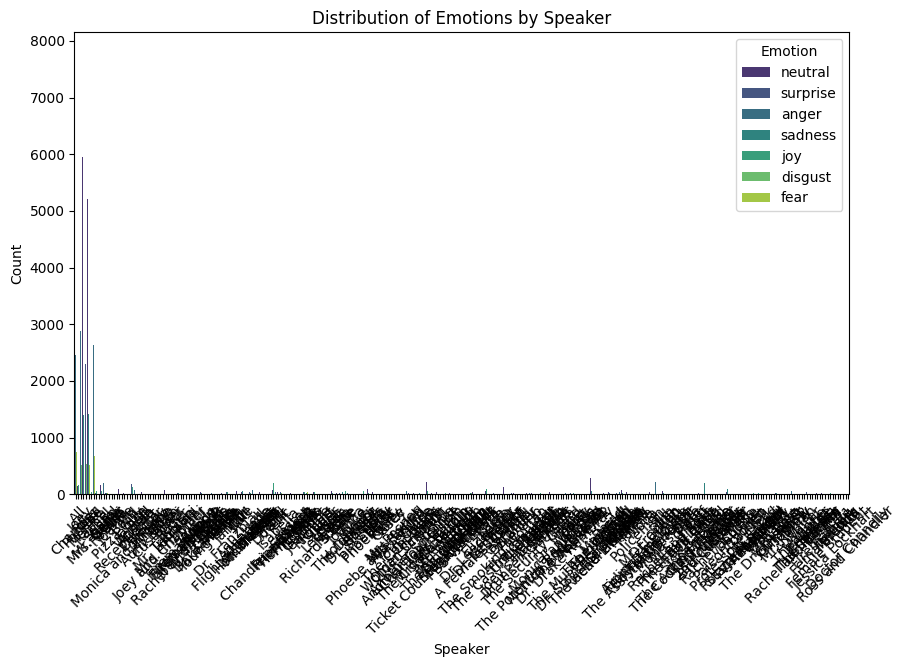

In [ ]:
# Distribution of emotions based on speaker
plt.figure(figsize=(10, 6))
sns.countplot(x='Speaker', hue='Emotion', data=train_df, palette='viridis')
plt.title('Distribution of Emotions by Speaker')
plt.xlabel('Speaker')
plt.ylabel('Count')
plt.legend(title='Emotion')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Define a function to extract emotion-cause pairs from a conversation
def extract_emotion_cause_pairs(conversation):
    pairs = []
    for utterance in conversation["conversation"]:
        emotion = utterance["emotion"]
        if emotion != "neutral":
            for cause_pair in conversation["emotion-cause_pairs"]:
                if str(utterance["utterance_ID"]) in cause_pair[1]:
                    pairs.append((emotion, cause_pair[1]))
    return pairs

# Process each conversation in the dataset
for conversation in data:
    emotion_cause_pairs = extract_emotion_cause_pairs(conversation)
    print("Conversation ID:", conversation["conversation_ID"])
    print("Emotion-Cause Pairs:")
    for pair in emotion_cause_pairs:
        print(pair)
    print()


Streaming output truncated to the last 5000 lines.

Conversation ID: 1255
Emotion-Cause Pairs:
('surprise', '1_your breasts')
('surprise', '13_I have a Ph . D .')
('fear', '3_you are coming on a little strong .')
('fear', '13_I have a Ph . D .')

Conversation ID: 1257
Emotion-Cause Pairs:
('sadness', '3_I am so ... so sorry about yesterday .')
('sadness', '3_I am so ... so sorry about yesterday .')
('sadness', '3_I am so ... so sorry about yesterday .')
('sadness', '3_I am so ... so sorry about yesterday .')
('sadness', '13_I ... I am gonna go .')
('sadness', '6_I understand why you were there .')
('sadness', '10_I wish that we can work it out Ross , but we can not .')
('sadness', '10_I wish that we can work it out Ross , but we can not .')
('sadness', '10_I wish that we can work it out Ross , but we can not .')
('sadness', '10_I wish that we can work it out Ross , but we can not .')
('sadness', '10_I wish that we can work it out Ross , but we can not .')
('sadness', '10_I wish that we

In [ ]:
import json

# Load and parse the JSON file
with open("Subtask_1_train.json", "r") as train_file:
    train_data = json.load(train_file)

# Iterate through conversations
for conversation in train_data:
    conversation_id = conversation["conversation_ID"]
    print(f"Conversation ID: {conversation_id}")

    # Extract emotion-cause pairs
    emotion_cause_pairs = conversation["emotion-cause_pairs"]
    for pair in emotion_cause_pairs:
        emotion, cause = pair
        print(f"Emotion: {emotion}, Cause: {cause}")


Streaming output truncated to the last 5000 lines.
Conversation ID: 1026
Emotion: 4_surprise, Cause: 4_How did you ... know ?
Emotion: 5_surprise, Cause: 5_What she doing back here ?
Conversation ID: 1028
Conversation ID: 1029
Emotion: 7_surprise, Cause: 8_That mail guy had no idea there was something going on between us .
Emotion: 8_surprise, Cause: 8_That mail guy had no idea there was something going on between us .
Conversation ID: 1030
Emotion: 4_surprise, Cause: 3_I will remember to put that in your evaluation .
Emotion: 8_joy, Cause: 8_I have just always wanted to do that .
Conversation ID: 1031
Emotion: 1_surprise, Cause: 1_The basket is totally empty ! My God , the neighbors ate all the candy !
Emotion: 3_anger, Cause: 5_Did you eat all the neighbor candy ? !
Emotion: 5_anger, Cause: 5_Did you eat all the neighbor candy ? !
Emotion: 6_anger, Cause: 6_by the time I got to it there was only a couple of pieces left !
Emotion: 8_joy, Cause: 7_they have been coming by all day . The

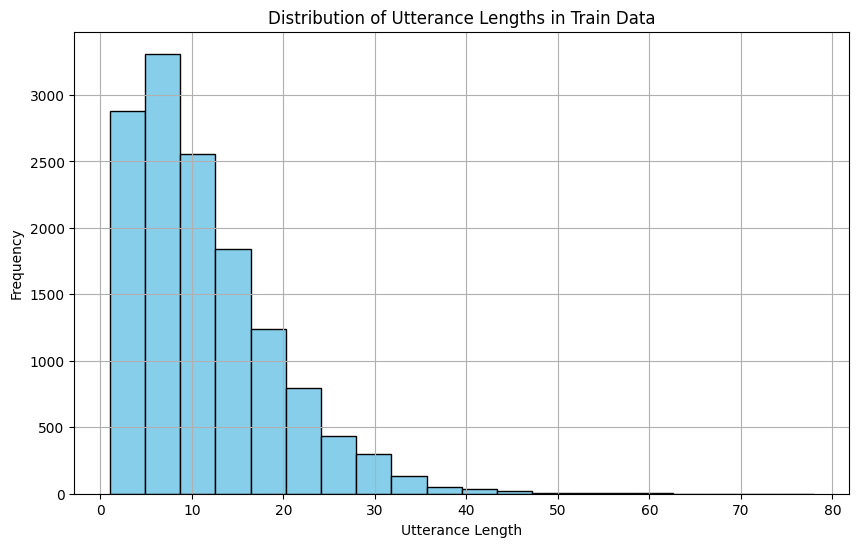

In [ ]:
utterance_lengths = [len(utterance['text'].split()) for conv in train_data for utterance in conv['conversation']]
plt.figure(figsize=(10, 6))
plt.hist(utterance_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Utterance Length')
plt.ylabel('Frequency')
plt.title('Distribution of Utterance Lengths in Train Data')
plt.grid(True)
plt.show()



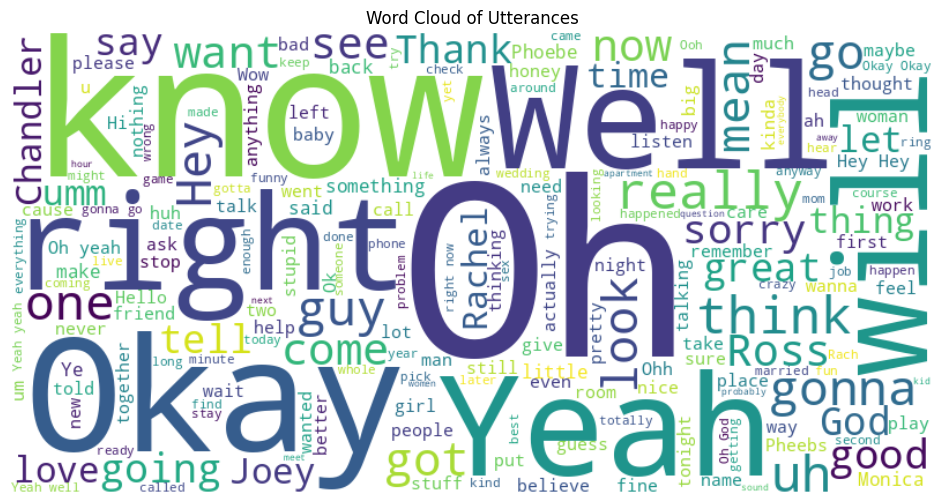

In [ ]:
from wordcloud import WordCloud

# Combine all utterances into a single string
all_text = ' '.join([utterance['text'] for conv in train_data for utterance in conv['conversation']])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Utterances')
plt.show()


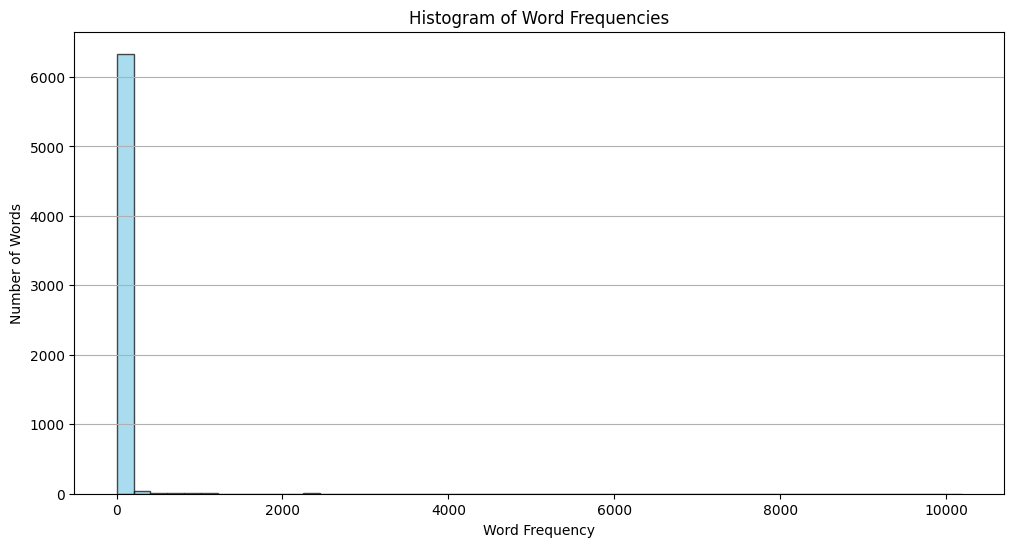

In [ ]:
from collections import Counter

# Tokenize all utterances
tokens = [word.lower() for conv in train_data for utterance in conv['conversation']
          for word in utterance['text'].split()]

# Count word frequencies
word_freq = Counter(tokens)

# Plot histogram of word frequencies
plt.figure(figsize=(12, 6))
plt.hist(word_freq.values(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Frequencies')
plt.grid(axis='y')
plt.show()


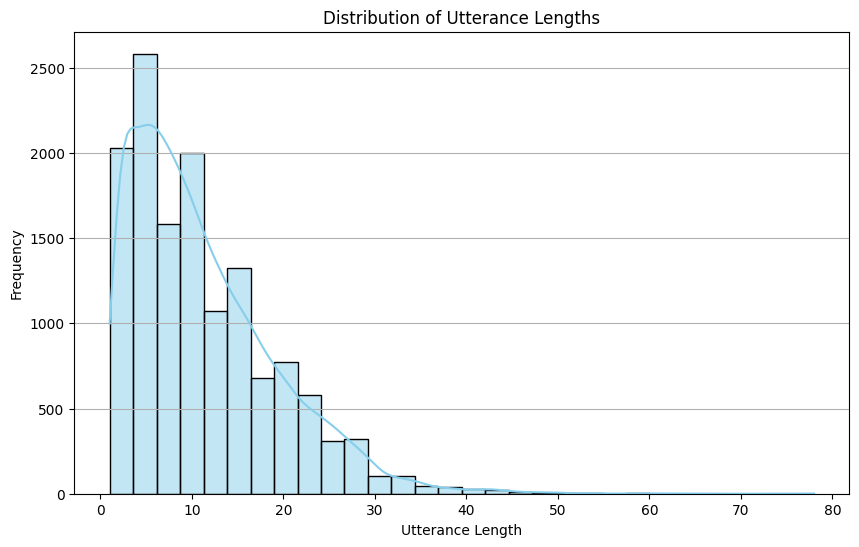

In [ ]:
# Calculate utterance lengths
utterance_lengths = [len(utterance['text'].split()) for conv in train_data for utterance in conv['conversation']]

# Plot distribution of utterance lengths
plt.figure(figsize=(10, 6))
sns.histplot(utterance_lengths, bins=30, kde=True, color='skyblue')
plt.xlabel('Utterance Length')
plt.ylabel('Frequency')
plt.title('Distribution of Utterance Lengths')
plt.grid(axis='y')
plt.show()


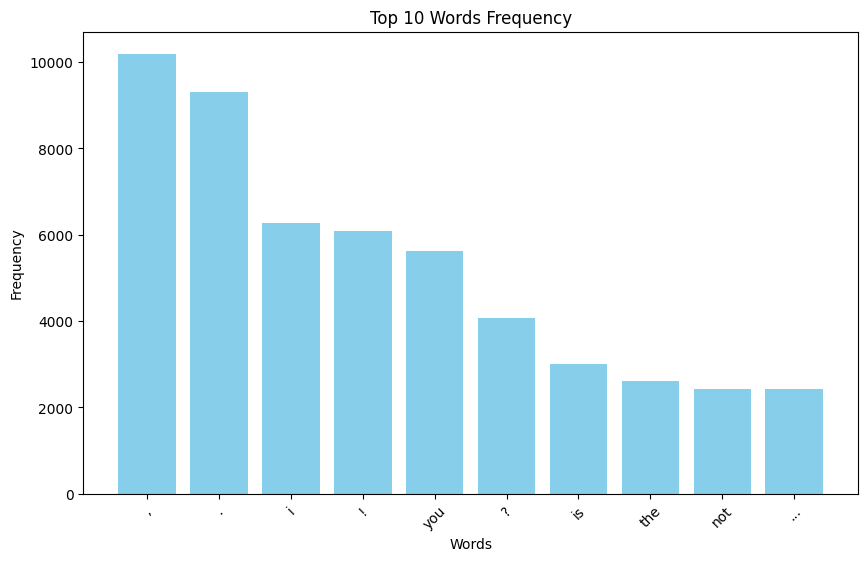

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Tokenize text and count word frequencies
tokens = [word.lower() for conv in train_data for utterance in conv['conversation']
          for word in utterance['text'].split()]
word_freq = Counter(tokens)

# Get top N words and their frequencies
top_n = 10
top_words = [word[0] for word in word_freq.most_common(top_n)]
top_freqs = [word_freq[word] for word in top_words]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words, top_freqs, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words Frequency'.format(top_n))
plt.xticks(rotation=45)
plt.show()


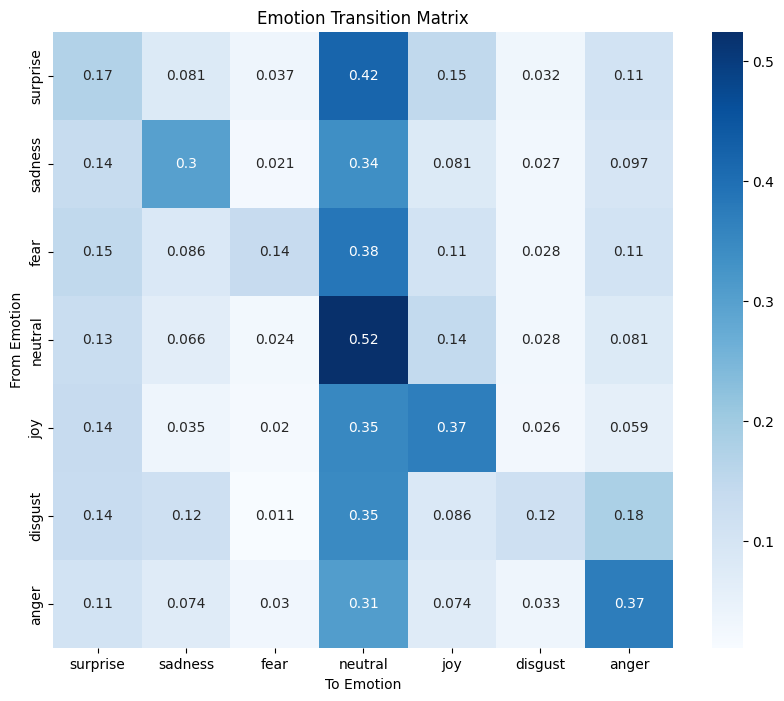

array([[0.17208183, 0.08122744, 0.03670277, 0.41997593, 0.14921781,
        0.03249097, 0.10830325],
       [0.13631938, 0.29990263, 0.02142162, 0.3369036 , 0.08081792,
        0.02726388, 0.09737098],
       [0.14769231, 0.08615385, 0.13846154, 0.38461538, 0.10769231,
        0.02769231, 0.10769231],
       [0.13212821, 0.06634365, 0.02441297, 0.52459933, 0.14424152,
        0.02758107, 0.08069325],
       [0.13925279, 0.0354197 , 0.01989326, 0.35031538, 0.37020864,
        0.02620087, 0.05870936],
       [0.13535912, 0.11878453, 0.01104972, 0.3480663 , 0.08563536,
        0.11878453, 0.18232044],
       [0.1074896 , 0.0742025 , 0.02981969, 0.30721221, 0.0742025 ,
        0.0332871 , 0.37378641]])

In [ ]:
import numpy as np

# Extract emotion transitions
emotion_transitions = [(conv['conversation'][i]['emotion'], conv['conversation'][i+1]['emotion'])
                       for conv in train_data for i in range(len(conv['conversation'])-1)]

# Create transition matrix
unique_emotions = set(emotion for transition in emotion_transitions for emotion in transition)
transition_matrix = np.zeros((len(unique_emotions), len(unique_emotions)))
for transition in emotion_transitions:
    i, j = list(unique_emotions).index(transition[0]), list(unique_emotions).index(transition[1])
    transition_matrix[i, j] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# Plot heatmap of transition matrix
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, xticklabels=unique_emotions, yticklabels=unique_emotions, cmap='Blues')
plt.xlabel('To Emotion')
plt.ylabel('From Emotion')
plt.title('Emotion Transition Matrix')
plt.show()

transition_matrix


**Logistic Regression**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Feature extraction
X = train_df['Text']  # Text as input feature
y_emotion = train_df['Emotion']  # Emotion labels as target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_emotion, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a logistic regression classifier
emotion_classifier = LogisticRegression()
emotion_classifier.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred_emotion = emotion_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_emotion))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       anger       0.73      0.66      0.70      3779
     disgust       0.87      0.57      0.68       888
        fear       0.68      0.42      0.52       679
         joy       0.74      0.67      0.70      4404
     neutral       0.69      0.83      0.75      9307
     sadness       0.74      0.58      0.65      2515
    surprise       0.72      0.72      0.72      3692

    accuracy                           0.72     25264
   macro avg       0.74      0.64      0.67     25264
weighted avg       0.72      0.72      0.71     25264



In [ ]:
X_train_tfidf

<101052x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 766624 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_tfidf

<25264x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 193441 stored elements in Compressed Sparse Row format>

In [ ]:
y_test

33778          joy
7984       neutral
42638     surprise
108645    surprise
37001          joy
            ...   
38772     surprise
90219        anger
42513        anger
65894      neutral
92582      sadness
Name: Emotion, Length: 25264, dtype: object

In [ ]:
y_train

4285       sadness
6188       neutral
979          anger
90293          joy
31284      neutral
            ...   
119879    surprise
103694     neutral
860          anger
15795      neutral
121958     sadness
Name: Emotion, Length: 101052, dtype: object

In [ ]:
import pandas as pd

# Assuming y_test and y_pred_emotion are defined as per your provided code
# Create a DataFrame with actual and predicted labels
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_emotion
})

# Add a column to check if the prediction matches the actual label
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

# Display the DataFrame
print(results_df.head())  # Displaying only the first few entries for brevity

# Additional analysis can be done to see overall accuracy
accuracy = results_df['Correct'].mean()
print(f"Overall accuracy: {accuracy:.2f}")


          Actual Predicted  Correct
33778        joy       joy     True
7984     neutral   neutral     True
42638   surprise   neutral    False
108645  surprise  surprise     True
37001        joy       joy     True
Overall accuracy: 0.72


In [ ]:
import pandas as pd

# Continue using the results_df DataFrame
# Group the data by 'Actual', 'Predicted', and 'Correct' status and count each group
label_counts = results_df.groupby(['Actual', 'Predicted', 'Correct']).size().reset_index(name='Count')

# Print the grouped and counted data
print(label_counts)


      Actual Predicted  Correct  Count
0      anger     anger     True   2512
1      anger   disgust    False     10
2      anger      fear    False     38
3      anger       joy    False    145
4      anger   neutral    False    765
5      anger   sadness    False     91
6      anger  surprise    False    218
7    disgust     anger    False     65
8    disgust   disgust     True    502
9    disgust      fear    False     12
10   disgust       joy    False     45
11   disgust   neutral    False    155
12   disgust   sadness    False     37
13   disgust  surprise    False     72
14      fear     anger    False     65
15      fear   disgust    False      1
16      fear      fear     True    285
17      fear       joy    False     18
18      fear   neutral    False    214
19      fear   sadness    False     40
20      fear  surprise    False     56
21       joy     anger    False    134
22       joy   disgust    False      3
23       joy      fear    False     10
24       joy       joy   

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get labels from the classifier
labels = emotion_classifier.classes_

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_emotion)
# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Print confusion matrix with labels and colors
print("Confusion Matrix:")
styled_conf_matrix = conf_matrix_df.style.background_gradient(cmap='Blues')
styled_conf_matrix



Confusion Matrix:


,anger,disgust,fear,joy,neutral,sadness,surprise
anger,2512,10,38,145,765,91,218
disgust,65,502,12,45,155,37,72
fear,65,1,285,18,214,40,56
joy,134,3,10,2948,1097,75,137
neutral,365,22,47,570,7705,209,389
sadness,157,28,14,111,596,1468,141
surprise,142,13,16,172,637,65,2647


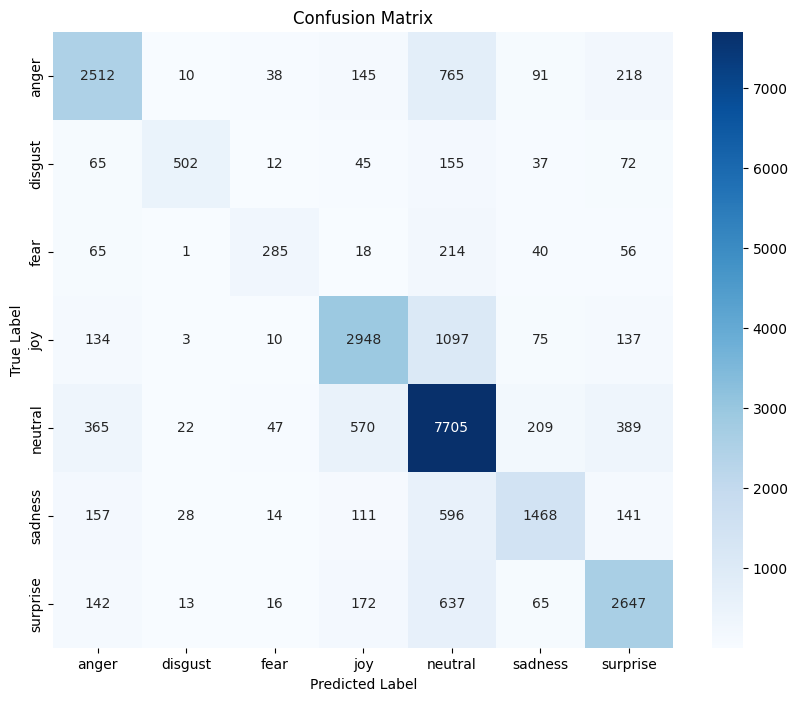

In [ ]:
# Plot heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Anger (True Label):

Most often confused with neutral (765 instances) and joy (145 instances).
Relatively few instances confused with disgust, fear, sadness, and surprise.

# Disgust (True Label):

Most often confused with neutral (155 instances) and anger (65 instances).
Fewer instances confused with fear, joy, sadness, and surprise.

# Fear (True Label):

Most often confused with neutral (214 instances) and anger (65 instances).
Fewer instances confused with joy, sadness, and surprise.

# Joy (True Label):

Most often confused with neutral (1097 instances) and anger (134 instances).
Fewer instances confused with disgust, fear, sadness, and surprise.

# Neutral (True Label):

Most often confused with joy (7705 instances) and anger (365 instances).
Some confusion with surprise, sadness, and disgust.

# Sadness (True Label):

Most often confused with neutral (596 instances) and anger (157 instances).
Fewer instances confused with disgust, fear, joy, and surprise.

# Surprise (True Label):

Most often confused with neutral (637 instances) and joy (172 instances).
Fewer instances confused with disgust, fear, sadness, and anger.

# Overall Analysis:

- The model performs relatively well in predicting joy, with the highest number of true positives (2948) and relatively fewer misclassifications compared to other emotions.
- Anger, neutral, and sadness are frequently confused with other emotions, indicating some difficulty in distinguishing these emotions from others.
- Disgust and fear have relatively lower instances overall and are less frequently confused with other emotions.
- The model seems to struggle the most with neutral, often misclassifying it as joy and vice versa, possibly indicating some overlap in the text features of these emotions.
- There's generally more confusion between neutral and other emotions compared to other pairs, suggesting that the model may have challenges in accurately distinguishing neutral emotions from others.

## **Trying BERT**

In [ ]:
!pip install accelerate>=0.21.0


In [ ]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 1.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import pandas as pd
import json

# Load data
with open('/content/Subtask_1_train.json', 'r') as file:
    data = json.load(file)


In [ ]:
# Prepare the DataFrame
def extract_data(data):
    rows = []
    for conversation in data:
        for pair in conversation['emotion-cause_pairs']:
            emotion, cause = pair
            utterance_id = emotion.split('_')[0]
            text = next(item for item in conversation['conversation'] if str(item['utterance_ID']) == utterance_id)['text']
            rows.append({'text': text, 'emotion': emotion.split('_')[1], 'cause': cause})
    return pd.DataFrame(rows)

df = extract_data(data)

In [ ]:
df

,text,emotion,cause
0,"Then I look down , and I realize there is a ph...",surprise,1_I realize I am totally naked .
1,"Then I look down , and I realize there is a ph...",surprise,"3_Then I look down , and I realize there is a ..."
2,Instead of ... ?,surprise,1_I realize I am totally naked .
3,Instead of ... ?,surprise,"3_Then I look down , and I realize there is a ..."
4,Instead of ... ?,surprise,4_Instead of ...
...,...,...,...
9359,"Oh , DAMN IT !",anger,10_keep having sex on a regular basis .
9360,"Ooh ! I am sorry ! I think , I THINK , that ma...",joy,1_that may have missed the table !
9361,DO YOU ?,anger,1_that may have missed the table !
9362,Why ?,surprise,"1_I never sucked , I actually did not want you..."


In [ ]:
conversations = pd.DataFrame(data)

In [ ]:
conversations

,conversation_ID,conversation,emotion-cause_pairs
0,1,"[{'utterance_ID': 1, 'text': 'Alright , so I a...","[[3_surprise, 1_I realize I am totally naked ...."
1,2,"[{'utterance_ID': 1, 'text': 'I do not want to...","[[1_sadness, 1_I do not want to be single], [3..."
2,3,"[{'utterance_ID': 1, 'text': 'Oh my God !', 's...","[[3_sadness, 3_I should have caught on when sh..."
3,4,"[{'utterance_ID': 1, 'text': 'Barry , I am sor...",[]
4,5,"[{'utterance_ID': 1, 'text': 'Oh , look , wish...","[[1_joy, 3_I am gonna go get one of those job ..."
...,...,...,...
1369,1346,"[{'utterance_ID': 1, 'text': 'Hey Ross , this ...",[]
1370,1357,"[{'utterance_ID': 1, 'text': 'Yeah , but what ...","[[1_fear, 1_if there is a reason why we can no..."
1371,1360,"[{'utterance_ID': 1, 'text': 'Wow ! Fortunatel...","[[2_surprise, 2_My uterus is an inhospitable e..."
1372,1371,"[{'utterance_ID': 1, 'text': 'Ooh ! I am sorry...","[[1_joy, 1_that may have missed the table !], ..."


In [ ]:
# Extracting data from the list of dictionaries
conversation_data = []
for conv in data:
    conv_id = conv['conversation_ID']
    for utt in conv['conversation']:
        utterance_id = utt['utterance_ID']
        text = utt['text']
        speaker = utt['speaker']
        emotion = utt['emotion']
        emotion_cause_pairs = conv['emotion-cause_pairs']
        for emotion_id, cause in emotion_cause_pairs:
            emotion_category, _ = emotion_id.split('_')
            conversation_data.append((conv_id, utterance_id, text, speaker, emotion, emotion_category, cause, (emotion_id, cause)))

# Create DataFrame
train_df = pd.DataFrame(conversation_data, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker', 'Emotion', 'Emotion_Category', 'Cause', 'Emotion_Cause_Pair'])

# Display DataFrame
train_df

,Conversation_ID,Utterance_ID,Text,Speaker,Emotion,Emotion_Category,Cause,Emotion_Cause_Pair
0,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,3,1_I realize I am totally naked .,"(3_surprise, 1_I realize I am totally naked .)"
1,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,3,"3_Then I look down , and I realize there is a ...","(3_surprise, 3_Then I look down , and I realiz..."
2,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,4,1_I realize I am totally naked .,"(4_surprise, 1_I realize I am totally naked .)"
3,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,4,"3_Then I look down , and I realize there is a ...","(4_surprise, 3_Then I look down , and I realiz..."
4,1,1,"Alright , so I am back in high school , I am s...",Chandler,neutral,4,4_Instead of ...,"(4_surprise, 4_Instead of ...)"
...,...,...,...,...,...,...,...,...
126311,1374,3,I do not know .,Chandler,neutral,4,4_Now we can enter into doubles tournaments !,"(4_joy, 4_Now we can enter into doubles tourna..."
126312,1374,4,This is so great ! Now we can enter into doubl...,Monica,joy,2,"1_I never sucked , I actually did not want you...","(2_surprise, 1_I never sucked , I actually did..."
126313,1374,4,This is so great ! Now we can enter into doubl...,Monica,joy,4,4_Now we can enter into doubles tournaments !,"(4_joy, 4_Now we can enter into doubles tourna..."
126314,1374,5,That is why !,Chandler,neutral,2,"1_I never sucked , I actually did not want you...","(2_surprise, 1_I never sucked , I actually did..."


In [ ]:
# Prepare datasets
def preprocess_function(examples):
    return tokenizer(examples['Combined'], truncation=True, padding=True)


In [ ]:

# Extracting [utterance, text, emotion] pairs as list of lists
utterance_text_emotion_list = []
for conversation in data:
    for utterance in conversation['conversation']:
        utterance_text_emotion_list.append([utterance['utterance_ID'], utterance['text'], utterance['emotion']])

# Convert the list to a DataFrame
df = pd.DataFrame(utterance_text_emotion_list, columns=['Utterance_ID', 'Text', 'Emotion'])

# Displaying the DataFrame
df


,Utterance_ID,Text,Emotion
0,1,"Alright , so I am back in high school , I am s...",neutral
1,2,"Oh , yeah . Had that dream .",neutral
2,3,"Then I look down , and I realize there is a ph...",surprise
3,4,Instead of ... ?,surprise
4,5,That is right .,anger
...,...,...,...
13614,1,"I never sucked , I actually did not want you t...",neutral
13615,2,Why ?,surprise
13616,3,I do not know .,neutral
13617,4,This is so great ! Now we can enter into doubl...,joy


In [ ]:
# prompt: Using dataframe df: combine all columns into one

df['Combined'] = df['Utterance_ID'].astype(str) + ' ' + df['Text'] + ' ' + df['Emotion']


In [ ]:
df

,Utterance_ID,Text,Emotion,Combined
0,1,"Alright , so I am back in high school , I am s...",neutral,"1 Alright , so I am back in high school , I am..."
1,2,"Oh , yeah . Had that dream .",neutral,"2 Oh , yeah . Had that dream . neutral"
2,3,"Then I look down , and I realize there is a ph...",surprise,"3 Then I look down , and I realize there is a ..."
3,4,Instead of ... ?,surprise,4 Instead of ... ? surprise
4,5,That is right .,anger,5 That is right . anger
...,...,...,...,...
13614,1,"I never sucked , I actually did not want you t...",neutral,"1 I never sucked , I actually did not want you..."
13615,2,Why ?,surprise,2 Why ? surprise
13616,3,I do not know .,neutral,3 I do not know . neutral
13617,4,This is so great ! Now we can enter into doubl...,joy,4 This is so great ! Now we can enter into dou...


In [ ]:
train_dataset = df.apply(preprocess_function, axis=1)

In [ ]:
train_dataset

0        [input_ids, token_type_ids, attention_mask]
1        [input_ids, token_type_ids, attention_mask]
2        [input_ids, token_type_ids, attention_mask]
3        [input_ids, token_type_ids, attention_mask]
4        [input_ids, token_type_ids, attention_mask]
                            ...                     
13614    [input_ids, token_type_ids, attention_mask]
13615    [input_ids, token_type_ids, attention_mask]
13616    [input_ids, token_type_ids, attention_mask]
13617    [input_ids, token_type_ids, attention_mask]
13618    [input_ids, token_type_ids, attention_mask]
Length: 13619, dtype: object

In [ ]:
# Extracting [utterance, text, emotion] pairs as list of lists
utterance_text_emotion_list = []
for conversation in data:
    for utterance in conversation['conversation']:
        utterance_text_emotion_list.append([utterance['utterance_ID'], utterance['text'], utterance['emotion']])

# Printing each item in the list dynamically
for item in utterance_text_emotion_list:
    output = ', '.join(f"{label}: {value}" for label, value in zip(['Utterance ID', 'Text', 'Emotion'], item))
    print(utterance_text_emotion_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[1, 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .', 'neutral'], [2, 'Oh , yeah . Had that dream .', 'neutral'], [3, 'Then I look down , and I realize there is a phone ... there .', 'surprise'], [4, 'Instead of ... ?', 'surprise'], [5, 'That is right .', 'anger'], [6, 'Never had that dream .', 'neutral'], [7, 'No .', 'neutral'], [8, 'All of a sudden , the phone starts to ring .', 'neutral'], [1, 'I do not want to be single , okay ? I just ... I just ... I just wanna be married again !', 'sadness'], [2, 'And I just want a million dollars !', 'neutral'], [3, 'Rachel ? !', 'surprise'], [1, 'Oh my God !', 'surprise'], [2, 'I know , I know , I am such an idiot .', 'neutral'], [3, 'I guess I should have caught on when she started going to the dentist four and five times a week . I mean , how clean can teeth get ?', 'sadness'], [4, 'My brother going through that right now , he is such a mess . How did you get through

KeyboardInterrupt: 

In [ ]:
# Define tokenizer and model
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df['Emotion'].unique()))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
type(utterance_text_emotion_list)

list

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)


# Train the model
trainer.train()


ImportError: cannot import name 'GradientAccumulationPlugin' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [ ]:
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load data from JSON file
with open('Subtask_1_test.json', 'r') as f:
    data1 = json.load(f)

# Extract data from the list of dictionaries
conversation_data1 = []
for conv in data1:
    conv_id = conv['conversation_ID']
    for utt in conv['conversation']:
        utterance_id = utt['utterance_ID']
        text = utt['text']
        speaker = utt['speaker']
        conversation_data1.append((conv_id, utterance_id, text, speaker))

# Create DataFrame
test_df1 = pd.DataFrame(conversation_data1, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker'])

# Tokenize and encode text data
inputs = tokenizer(test_df1['Text'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Perform emotion prediction
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1)

# Map predicted label indices to emotions
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness']
predicted_emotions = [emotion_labels[label] for label in predicted_labels]

# Add predicted emotions to DataFrame
test_df1['Predicted_Emotions'] = predicted_emotions

# Display DataFrame with predicted emotions
print(test_df1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

FileNotFoundError: [Errno 2] No such file or directory: 'Subtask_1_test.json'

In [ ]:
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def predict_emotions(json_file_path, model_name):
    """
    Predict emotions for text data in a JSON file using a pre-trained model.

    Args:
    json_file_path (str): Path to the JSON file containing conversation data.
    model_name (str): Name or path of the pre-trained model.

    Returns:
    pd.DataFrame: DataFrame with predicted emotions added as a new column.
    """
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Load data from JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Extract data from the list of dictionaries
    conversation_data = []
    for conv in data:
        conv_id = conv['conversation_ID']
        for utt in conv['conversation']:
            utterance_id = utt['utterance_ID']
            text = utt['text']
            speaker = utt['speaker']
            conversation_data.append((conv_id, utterance_id, text, speaker))

    # Create DataFrame
    df = pd.DataFrame(conversation_data, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker'])

    # Tokenize and encode text data
    inputs = tokenizer(df['Text'].tolist(), padding=True, truncation=True, return_tensors="pt")

    # Perform emotion prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted labels
    predicted_labels = torch.argmax(outputs.logits, dim=1)

    # Map predicted label indices to emotions
    emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness']
    predicted_emotions = [emotion_labels[label] for label in predicted_labels]

    # Add predicted emotions to DataFrame
    df['Predicted_Emotions'] = predicted_emotions

    return df

# Usage example
json_file_path = 'Subtask_1_test.json'
model_name = "j-hartmann/emotion-english-distilroberta-base"

predicted_df = predict_emotions(json_file_path, model_name)
print(predicted_df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
with open('Subtask_1_test.json', 'r') as f:
    data1 = json.load(f)

In [ ]:

# Extracting data from the list of dictionaries
conversation_data1 = []
for conv in data1:
    conv_id = conv['conversation_ID']
    for utt in conv['conversation']:
        utterance_id = utt['utterance_ID']
        text = utt['text']
        speaker = utt['speaker']
        conversation_data1.append((conv_id, utterance_id, text, speaker))

# Create DataFrame
test_df1 = pd.DataFrame(conversation_data1, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker'])

# Display DataFrame
test_df1

# Question Answering

In [ ]:
!pip install transformers

In [ ]:
pip install --upgrade transformers


In [ ]:
from transformers import pipeline
update transformers
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

In [ ]:
with open('Subtask_1_test.json', 'r') as f:
    data1 = json.load(f)

In [ ]:

# Extracting data from the list of dictionaries
conversation_data1 = []
for conv in data1:
    conv_id = conv['conversation_ID']
    for utt in conv['conversation']:
        utterance_id = utt['utterance_ID']
        text = utt['text']
        speaker = utt['speaker']
        conversation_data1.append((conv_id, utterance_id, text, speaker))

# Create DataFrame
test_df1 = pd.DataFrame(conversation_data1, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker'])

# Display DataFrame
test_df1

In [ ]:
results_df

# BERT

In [ ]:
with open('Subtask_1_train.json', 'r') as f:
    data = json.load(f)

In [ ]:
# Extracting data from the list of dictionaries
conversation_data = []
for conv in data:
    conv_id = conv['conversation_ID']
    for utt in conv['conversation']:
        utterance_id = utt['utterance_ID']
        text = utt['text']
        speaker = utt['speaker']
        emotion = utt['emotion']
        emotion_cause_pairs = conv['emotion-cause_pairs']
        conversation_data.append((conv_id, utterance_id, text, speaker, emotion, emotion_cause_pairs))

# Create DataFrame
train_df = pd.DataFrame(conversation_data, columns=['Conversation_ID', 'Utterance_ID', 'Text', 'Speaker', 'Emotion', 'Emotion_Cause_Pairs'])

# Display DataFrame
train_df


In [ ]:
dfConvo = pd.DataFrame(train_df['Text'])
dfConvo

In [ ]:
dfEmo = pd.DataFrame(train_df['Emotion'])
dfEmo

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
# Define BERT model architecture
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)  # Adjust num_labels according to your task
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Training
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
batch_size = 8
max_length = 128

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for start in range(0, len(dfConvo), batch_size):
        end = min(start + batch_size, len(dfConvo))
        batch_text = dfConvo['Text'][start:end]
        batch_labels = dfEmo['Emotion'][start:end]

        # Tokenize batch text
        encoding = tokenizer(batch_text.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        labels = torch.tensor([tokenizer.config.label2id[label] for label in batch_labels], dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    accuracy = total_correct / total_samples
    loss_value = total_loss / (len(dfConvo) // batch_size + 1)
    epoch_num = epoch + 1

    print(f"Epoch {epoch_num}, Loss: {loss_value:.4f}, Accuracy: {accuracy * 100:.2f}%")

In [ ]:
targets

In [ ]:
#Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EmotionDataset(Dataset):
    def __init__(self, dfConvo, targets, tokenizer, max_length=128):
        self.encodings = tokenizer(dfConvo, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(targets)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# Example usage:
train_dataset = EmotionDataset(dfConvo, targets, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
# Define BERT model architecture
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
